In [1]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

token_transform = {}
vocab_transform = {}

In [2]:
pip install -U datasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
from datasets import load_dataset

TRAIN = load_dataset("wmt16", "de-en", split="train[:200000]")
TEST = load_dataset("wmt16", "de-en", split="test")
VALIDATION = load_dataset("wmt16", "de-en", split="validation")

In [4]:
import torch

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data['translation']
        self.de = []
        self.en = []

        for example in self.data:
            self.de.append(example['de'])
            self.en.append(example['en'])


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.de[idx], self.en[idx]

In [6]:
train_set = Dataset(TRAIN)
val_set = Dataset(VALIDATION)
test_Set = Dataset(TEST)

In [7]:
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 20.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [8]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3

special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    
    train_iter = train_set
    
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [9]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [10]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [11]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 4
FFN_HID_DIM = 128
BATCH_SIZE = 32
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/home/manav/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [12]:
from torch.nn.utils.rnn import pad_sequence


def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func


def tensor_transform(token_ids):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))


text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], 
                                               vocab_transform[ln], 
                                               tensor_transform) 



def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [13]:
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = train_set
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()


    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0
    val_iter = val_set
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [50]:
from timeit import default_timer as timer


NUM_EPOCHS = 5

train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 1, Train loss: 4.509, Val loss: 5.488, Epoch time = 691.647s
Epoch: 2, Train loss: 3.405, Val loss: 5.072, Epoch time = 692.866s
Epoch: 3, Train loss: 2.978, Val loss: 4.882, Epoch time = 691.724s
Epoch: 4, Train loss: 2.737, Val loss: 4.819, Epoch time = 693.994s
Epoch: 5, Train loss: 2.583, Val loss: 4.774, Epoch time = 694.476s


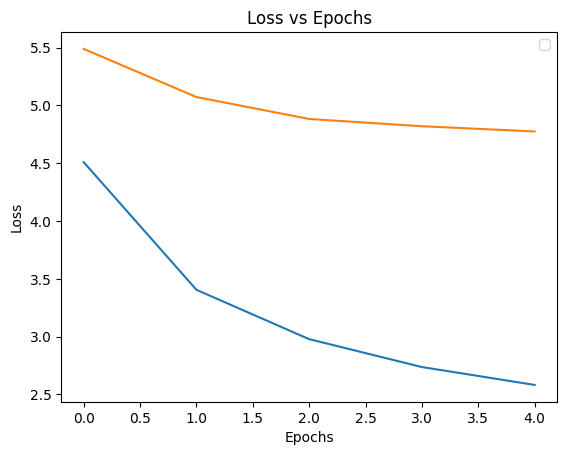

In [51]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()

In [ ]:
PATH = "2A.pt"

torch.save({
            'epoch': NUM_EPOCHS,
            'model_state_dict': transformer.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

In [14]:
checkpoint = torch.load("2A.pt")
transformer.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [15]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [16]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))

 A group of people are still being a security system . 


In [17]:
pip install evaluate

Note: you may need to restart the kernel to use updated packages.


In [18]:
test_set = Dataset(TEST)
val_set = Dataset(VALIDATION)

sample = test_set[25]
prediction = translate(transformer, sample[0])
reference = sample[1]

In [19]:
prediction

" A other minute ' s silence , a single currency , said that the European Union was told that it was the end of the academic year . "

In [20]:
reference

'Another student, Mikel Sykes, said Lamb told him he was dealing with stress at the end of the 2014-15 academic year.'

# Evaluation Metrics

In [21]:
val_predictions = []
val_references = []

test_predictions = []
test_references = []

for sample in val_set:
  reference = sample[1]
  prediction = translate(transformer, sample[0])

  val_predictions.append(prediction)
  val_references.append(reference)

for sample in test_set:
  reference = sample[1]
  prediction = translate(transformer, sample[0])

  test_predictions.append(prediction)
  test_references.append(reference)



In [22]:
import evaluate

bleu = evaluate.load("bleu")
val_bleu1 = bleu.compute(predictions=val_predictions, references=val_references, max_order=1)
test_bleu1 = bleu.compute(predictions=test_predictions, references=test_references, max_order=1)

val_bleu1, test_bleu1

/home/manav/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


({'bleu': 0.36666801080688743,
  'precisions': [0.3666680108068874],
  'brevity_penalty': 1.0,
  'length_ratio': 1.0679327347501237,
  'translation_length': 49598,
  'reference_length': 46443},
 {'bleu': 0.37265239818746615,
  'precisions': [0.37265239818746615],
  'brevity_penalty': 1.0,
  'length_ratio': 1.094496171181709,
  'translation_length': 70178,
  'reference_length': 64119})

In [23]:
val_bleu2 = bleu.compute(predictions=val_predictions, references=val_references, max_order=2)
test_bleu2 = bleu.compute(predictions=test_predictions, references=test_references, max_order=2)

val_bleu2, test_bleu2

({'bleu': 0.2153545035148271,
  'precisions': [0.3666680108068874, 0.12648379683316113],
  'brevity_penalty': 1.0,
  'length_ratio': 1.0679327347501237,
  'translation_length': 49598,
  'reference_length': 46443},
 {'bleu': 0.223102289300297,
  'precisions': [0.37265239818746615, 0.13356852587862278],
  'brevity_penalty': 1.0,
  'length_ratio': 1.094496171181709,
  'translation_length': 70178,
  'reference_length': 64119})

In [24]:
val_bleu3 = bleu.compute(predictions=val_predictions, references=val_references, max_order=3)
test_bleu3 = bleu.compute(predictions=test_predictions, references=test_references, max_order=3)

val_bleu3, test_bleu3

({'bleu': 0.13552011516501977,
  'precisions': [0.3666680108068874, 0.12648379683316113, 0.05366651200813062],
  'brevity_penalty': 1.0,
  'length_ratio': 1.0679327347501237,
  'translation_length': 49598,
  'reference_length': 46443},
 {'bleu': 0.1423458596909431,
  'precisions': [0.37265239818746615,
   0.13356852587862278,
   0.05794640074789654],
  'brevity_penalty': 1.0,
  'length_ratio': 1.094496171181709,
  'translation_length': 70178,
  'reference_length': 64119})

In [25]:
val_bleu4 = bleu.compute(predictions=val_predictions, references=val_references, max_order=4)
test_bleu4 = bleu.compute(predictions=test_predictions, references=test_references, max_order=4)

val_bleu4, test_bleu4

({'bleu': 0.08876632014376198,
  'precisions': [0.3666680108068874,
   0.12648379683316113,
   0.05366651200813062,
   0.024944889198282864],
  'brevity_penalty': 1.0,
  'length_ratio': 1.0679327347501237,
  'translation_length': 49598,
  'reference_length': 46443},
 {'bleu': 0.09420957621736477,
  'precisions': [0.37265239818746615,
   0.13356852587862278,
   0.05794640074789654,
   0.027311508098654857],
  'brevity_penalty': 1.0,
  'length_ratio': 1.094496171181709,
  'translation_length': 70178,
  'reference_length': 64119})

In [26]:
meteor = evaluate.load("meteor")
val_meteor = meteor.compute(predictions=val_predictions, references=val_references)
test_meteor = meteor.compute(predictions=test_predictions, references=test_references)

val_meteor, test_meteor

[nltk_data] Downloading package wordnet to /home/manav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/manav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/manav/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


({'meteor': 0.316223179323813}, {'meteor': 0.33026008261526635})

In [27]:
pip install bert_score

Note: you may need to restart the kernel to use updated packages.


In [28]:
bertscore = evaluate.load("bertscore")

val_bert = bertscore.compute(predictions=val_predictions, references=val_references, lang='en')
test_bert = bertscore.compute(predictions=test_predictions, references=test_references, lang='en')

val_bert, test_bert

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


({'precision': [0.8938906192779541,
   0.8488746881484985,
   0.8657823801040649,
   0.8591002821922302,
   0.8922538757324219,
   0.8185385465621948,
   0.837213397026062,
   0.8236629366874695,
   0.8160181045532227,
   0.8506780862808228,
   0.8324519395828247,
   0.8282421827316284,
   0.8288893699645996,
   0.8255344033241272,
   0.8083581924438477,
   0.856440007686615,
   0.8339972496032715,
   0.8340426683425903,
   0.834661066532135,
   0.8623960614204407,
   0.8680738210678101,
   0.861960768699646,
   0.8227637410163879,
   0.8376442790031433,
   0.8694260120391846,
   0.8388547897338867,
   0.961548924446106,
   0.8700695037841797,
   0.858891487121582,
   0.8937650918960571,
   0.8329131603240967,
   0.8836314082145691,
   0.853206992149353,
   0.8906540870666504,
   0.8637763857841492,
   0.8669887185096741,
   0.9084597229957581,
   0.8918889164924622,
   0.8516369462013245,
   0.7979836463928223,
   0.8529502749443054,
   0.8495551347732544,
   0.8841878771781921,
   0.

In [34]:
val_bert

{'precision': [0.8938906192779541,
  0.8488746881484985,
  0.8657823801040649,
  0.8591002821922302,
  0.8922538757324219,
  0.8185385465621948,
  0.837213397026062,
  0.8236629366874695,
  0.8160181045532227,
  0.8506780862808228,
  0.8324519395828247,
  0.8282421827316284,
  0.8288893699645996,
  0.8255344033241272,
  0.8083581924438477,
  0.856440007686615,
  0.8339972496032715,
  0.8340426683425903,
  0.834661066532135,
  0.8623960614204407,
  0.8680738210678101,
  0.861960768699646,
  0.8227637410163879,
  0.8376442790031433,
  0.8694260120391846,
  0.8388547897338867,
  0.961548924446106,
  0.8700695037841797,
  0.858891487121582,
  0.8937650918960571,
  0.8329131603240967,
  0.8836314082145691,
  0.853206992149353,
  0.8906540870666504,
  0.8637763857841492,
  0.8669887185096741,
  0.9084597229957581,
  0.8918889164924622,
  0.8516369462013245,
  0.7979836463928223,
  0.8529502749443054,
  0.8495551347732544,
  0.8841878771781921,
  0.8798036575317383,
  0.8325845003128052,
  0.

In [35]:
avg_val_bert = {}

for key in val_bert:
    if key == "hashcode":
        continue
    avg_val_bert[key] = sum(val_bert[key])/len(val_bert[key])

avg_val_bert

{'precision': 0.8567657980461613,
 'recall': 0.864513774767841,
 'f1': 0.8605014695006618}

In [36]:
avg_test_bert = {}

for key in test_bert:
    if key == "hashcode":
        continue
    avg_test_bert[key] = sum(test_bert[key])/len(test_bert[key])

avg_test_bert

{'precision': 0.855689146432053,
 'recall': 0.861997166129898,
 'f1': 0.8587042163832659}

# Inference Pipeline - 2A

In [26]:
dutch = "Eine Gruppe von Menschen steht vor einem Iglu ."

print(f"Dutch scentence is: {dutch}")
print(f"English translation is: {translate(transformer, dutch)}")

Dutch scentence is: Eine Gruppe von Menschen steht vor einem Iglu .
English translation is:  A group of people are still being a security system . 


In [21]:
import pandas as pd

input_csv = pd.read_csv("input.csv")

In [22]:
output = {'de':[], 'en':[]}

for sample in input_csv['de']:
    output['de'].append(sample)
    output['en'].append(translate(transformer, sample))

output_csv = pd.DataFrame(output)
output_csv.to_csv("output.csv")